# HO calving model

Implementation of a simple calving law. The notebook starts by solving for basal elevation. Once the bed is determined, we forward model with calving. The underlying flow model is the Higher Order, or Blatter-Pattyn, approximation. 

The inversion follows the approach of [van Pelt et al. (2013)](https://tc.copernicus.org/articles/7/987/2013/), iteratively adjusting the bed to minimize the surface misfit after forward modeling. The procedure is implemented using the [centerflow_extruded](https://github.com/chrismiele/glimmer/blob/main/1D_modelling/centerflow_extruded.ipynb) package, which is built on top of Firedrake and icepack. 

Begin by choosing a glacier:

In [1]:
name = 'Luggye' #choose your glacier from the list below, or add another

freeboard = 50
c_1, c_2 = -2.0, 10 #calving parameters

## Glacier identification

Hard coding IDs for Bechung, Thorthormi, Rahpstreng, and Luggye. For other glaciers, it will be necessary to find their RGIIDs from v. 7.

In [2]:
glaciers = {
    'Luggye': {
        'name': 'Luggye',
        'rgiid_7': '15-09534',
    },
    'Raphstreng': {
        'name': 'Raphstreng',
        'rgiid_7': '15-09531',
    },
    'Thorthormi': {
        'name': 'Thorthormi',
        'rgiid_7': '15-09532',
    },
    'Bechung': {
        'name': 'Bechung',
        'rgiid_7': '15-09530',
    }
}

## Imports

In [3]:
from firedrake import *
import icepack
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import numpy as np
import os
import pandas as pd
import tqdm

os.chdir('/eejit/home/bezu0001/icepack/notebooks/GLIMMER/1D_modelling')
from centerflow_extruded import *

## Paths

In [4]:
rgiid_7 = glaciers[name]['rgiid_7']
base_path = '/eejit/home/bezu0001/data/'
centerline_path = base_path + 'centerlines/RGI2000-v7.0-L-15_south_asia_east/RGI2000-v7.0-L-15_south_asia_east.shp'
outline_path = base_path + 'outlines/RGI2000-v7.0-G-15_south_asia_east/RGI2000-v7.0-G-15_south_asia_east.shp'
outline6_path = base_path + 'outlines/nsidc0770_15.rgi60.SouthAsiaEast/15_rgi60_SouthAsiaEast.shp'

rgiid_6 = rgi6_from_rgi7(rgiid = rgiid_7, rgi7_path = outline_path, rgi6_path = outline6_path)
latlon = latlon_from_rgi7(rgiid = rgiid_7, rgi7_path = outline_path)

velocity_path = base_path + f'velocity/{rgiid_7}/MedianVelocity_2006.tif'
thickness_path = base_path + f'thickness/farinotti_ensemble/RGI60-{rgiid_6}_thickness.tif'
smb_path = base_path + 'smb/dussailant/ASE_gla_MEAN-CAL-mass-change-series_obs_unobs.csv'
# smb_path = base_path + 'smb/karma/prf_glacier_ctl.csv'

dem_path = base_path + f'elevation/farinotti/surface_DEM_RGI60-{rgiid_6}.tif'
dem_year = 2017 #the year corresponding to the DEM (probably somewhat earlier than RGI6, which was released in 2017)
start_year, end_year = 2010, 2020

dhdt_path = base_path + f'elevation/elevation_change/{start_year}_2020_dhdt/{latlon}_{start_year}-01-01_2020-01-01_dhdt.tif'

figures_path = '/eejit/home/bezu0001/icepack/figures/HO_calving'

## Load and adjust data

Because ```icepack``` assumes that the waterline is at sea level, things run more smoothly if we shift the dem downward so that 0 is lake level. Meanwhile, surface mass balance measurements are too negative to support much forward modeling, so these are shifted as well. Finally, higher-order model convergence struggles with bumpy data, so smoothing is performed on all input datasets, using ```smooth_function```, which is defined in [centerflow_extruded](https://github.com/chrismiele/glimmer/blob/main/1D_modelling/centerflow_extruded.ipynb). 

In [5]:
n_cells = 200

mesh = centerline_mesh(rgiid = rgiid_7, centerline_path = centerline_path, outline_path = outline_path, n_cells = n_cells)
mesh = crop_mesh(mesh = mesh, data_path = dem_path)
cell_size = int(mesh.length/n_cells)
print(f'average cell size = {cell_size} m')

thickness = map_to_mesh(mesh = mesh, data_path = thickness_path)
dem = map_to_mesh(mesh = mesh, data_path = dem_path)

Q = dem.function_space() #function space for depth-invariant quantities
Q_flat = icepack.depth_average(dem).function_space()
V = FunctionSpace(mesh.mesh, 'CG', 1, vfamily = 'GL', vdegree = 2) #function space for quantities which vary with depth
x, ζ = SpatialCoordinate(mesh.mesh) #ζ ranges from 0 (base) to 1 (surface)
X = mesh.X
coords_surface = mesh.surface_coords
coords_base = mesh.basal_coords

smoothing_params = {'window': 3*cell_size, 'mesh': mesh}

dem_adjusted = Function(Q).project(dem - dem.at(mesh.length, 1/2) + freeboard)
dem_adjusted = smooth_function(function = dem_adjusted, **smoothing_params)
thickness = smooth_function(function = thickness, **smoothing_params)

try:
    velocity = map_to_mesh(mesh = mesh, data_path = velocity_path, ice_free_value = 0)
    velocity = smooth_function(function = velocity, **smoothing_params)
    # velocity_shape = (1 - (1 - ζ)**4) #the vertical velocity profile follows this shape, assuming n = 3
    velocity_shape = 1e-10 #or just zero out the velocity?
    u_0 = Function(V).project(velocity_shape*velocity) #use this velocity for our boundary condition
except:
    velocity = Function(Q).project(Constant(1e-10))
    u_0 = Function(V).project(velocity)

dH_dt_unsmoothed = map_to_mesh(mesh = mesh, data_path = dhdt_path, ice_free_value = 0)
dH_dt = smooth_function(function = dH_dt_unsmoothed, window = mesh.length/4, mesh = mesh)
mean_dHdt  = float(assemble(dH_dt*dx)/mesh.length)

print('mean thinning rate:', mean_dHdt, 'meters per year')

average cell size = 42 m
mean thinning rate: -0.46690835759563204 meters per year


## Initialize the flow model

Depending on basal topography and glacier thickness evolution, the glacier may at times become ungrounded. To account for this, we define a new basal friction function which decreases with proximity to flotation. For this notebook, we assume the lake has the density of seawater, allowing ```icepack.compute_surface``` to straightforwardly determine where the glacier begins floating. 

In [6]:
def basal_friction(**kwargs): #function to scale the basal friction by fraction above flotation
    H = kwargs['thickness']
    s = kwargs['surface']
    u = kwargs['velocity']
    C = kwargs['friction']

    b = s - H
    ϱ = icepack.constants.ice_density/icepack.constants.water_density 

    flotation_surface = (1 - ϱ)*H #given the current thickness, this is the hypothetical surface elevation which would float the shelf
    h_af = s - flotation_surface #height above flotation
    frac_af = firedrake.min_value(h_af/H, 1) #fraction above flotation, capped at unity
    
    return icepack.models.hybrid.bed_friction(velocity = u, friction = C*frac_af)

T = 273.15 - 5 #ice temperature (K), assumed isothermal
A = Constant(icepack.rate_factor(T))
C = Constant(0.1)

model_opts = {'dirichlet_ids': [1]}
flow_model = icepack.models.HybridModel(friction = basal_friction)
flow_solver = icepack.solvers.FlowSolver(flow_model, **model_opts)

Δt = 1/10
num_timesteps = int((end_year - start_year)/Δt)

## Initialize reference surfaces

In [7]:
s_1 = dem_adjusted.copy(deepcopy = True)
s_1.year = dem_year

s_0 = Function(Q).project(s_1 - dH_dt*(dem_year - start_year))
s_0.year = start_year

s_2 = Function(Q).project(s_1 + dH_dt*(end_year - dem_year))
s_2.year = end_year

## Initialize SMB data

SMB data consist of single glacier-averaged values at each timestep. The inversion performs poorly with data this coarse. We can create slightly more realistic data by assuming that SMB varies with elevation via some lapse rate, and we construct a spatially variable SMB field whose spatial average is the appropriate value. The lapse rate is chosen so that the spread in SMB values is similar to the spread in the observed thinning rate. 

In [8]:
df = pd.read_csv(smb_path)
row = df.loc[df["RGIId"] == f'RGI60-{rgiid_6}']

lapse_rate = 0.003 #obtained by trial and error

smb_expr = lapse_rate*dem_adjusted #SMB is of the form smb = a*elevation + b, where a is the lapse rate and b is to be determined
temp_mean = assemble(smb_expr*dx)/mesh.length #the spatial mean of the expression smb = a*elevation + 0, which will need correcting

smb_dict = {} #list of glacier-wide specific SMB values (one per year)
for step in range(num_timesteps):
    decimal_year = s_0.year + step*Δt
    int_year = s_0.year + int(step*Δt)
    smb_mean = float(row[str(int_year)].iloc[0])
    b = smb_mean - temp_mean #how far off is our guess?
    entry = Function(Q).project(smb_expr + b) #adjust by this much
    smb_dict[decimal_year] = entry

## Invert for basal topography

In [9]:
surface_1 = s_0
surface_2 = s_2

inversion_params = {
    'model': flow_model,
    'solver': flow_solver,
    'mesh': mesh,
    'fluidity': A,
    'friction': C,
    'surface': surface_1,
    'surface_2': surface_2
}
    
inversion = solve_bed(K = 0.1, num_iterations = 40, thickness_guess = Constant(200), velocity = u_0, accumulation = smb_dict, 
                      **inversion_params)

100%|███████████████████████████████████████████████████████████████████████████████████| 40/40 [02:42<00:00,  4.06s/it]


## Calving modeling

We implement the simple calving law similar to that introduced by [Oerlemans and Nick, 2005](https://www.cambridge.org/core/journals/annals-of-glaciology/article/minimal-model-of-a-tidewater-glacier/C6B72F547D8C44CDAAAD337E1F2FC97F), in which the calving flux, in cubic meters per year, is given as 

$$ F_c = cdH_tw_t $$

where $d$ is water depth, $H_t$ is terminus thickness, $w_t$ is the terminus width, and $c$ is a tuning parameter whose units are a$^{-1}$. We modify this to a calving rate $u_c$ by dividing out the width dimension, and normalizing via:

$$u_c = c_1\sqrt{dH_t}.$$

We begine by specifying a given lake level, with water depth the difference between that level and the bed. At each timestep, we assume the glacier incrementally moves forward in accordance with its terminal velocity, and that it moves backward (if applicable) in accordance with the calving rate specified above. In order to test the ability of our model to also capture advance, we add an element of randomness to calving behaviour, expressing the likelihood of calving, in a given timestep, as:

$$p_{calving} = c_2\Delta t f_{af}$$

where $f_{af}$ is the fraction above flotation at the terminus (and if this value becomes negative, a calving event is imposed). If this probability criterion is not met in a given step, "calving pressure" accumulates, so that the next calving event is larger. Thus, calving events become smaller and more frequent as the terminus retreats from deep water, mimicking a transition to serac collapse of a well-grounded glacier. Meanwhile, the coarser the time resolution, the more likely a calving event is to occur in a given timestep. 

In [10]:
Q = inversion.surface.function_space()
ϱ = icepack.constants.ice_density/icepack.constants.water_density

bed = inversion.bed
s = surface_1.copy(deepcopy = True)
a = Function(Q).project(smb_dict[surface_1.year])
u = inversion.velocity
H = Function(Q).project(s - bed)
flotation_surface = (1 - ϱ)*H 
base = Function(Q).project(conditional(s >= flotation_surface, bed, -ϱ*H)) #make sure we've got the right basal elevation

H_0 = Constant(H.at(0, 0))
bed_t = icepack.depth_average(bed).at(mesh.length, tolerance = 1e-10)
x_t = mesh.length

Δx = 300 #extend the domain to permit advance
mesh_0 = centerline_mesh(mesh = mesh, n_cells = n_cells, extra_length = Δx)
mesh_1 = mesh
bed_0 = extend_to_mesh(function = bed, mesh = mesh_0, ice_free_value = bed_t)

bed0_array = np.array(icepack.depth_average(bed_0).at(mesh_0.X, tolerance = 1e-10))
d = Function(Q).project(max_value(-base, 0))
print(f'initial water depth = {d.at(x_t, 0)} m')

os.chdir(figures_path)
Δxs = []
fafs = []

model_time = surface_2.year - surface_1.year

x_1, x_2 = mesh_0.length - 2000, mesh_0.length
y_1 = bed_0.at((x_2, 0), tolerance = 1e-10) - 100
y_2 = s.at((x_1, 0), tolerance = 1e-10) + 100

initial water depth = 31.453403736219567 m


Text(0.5, 1.0, 'initial setup')

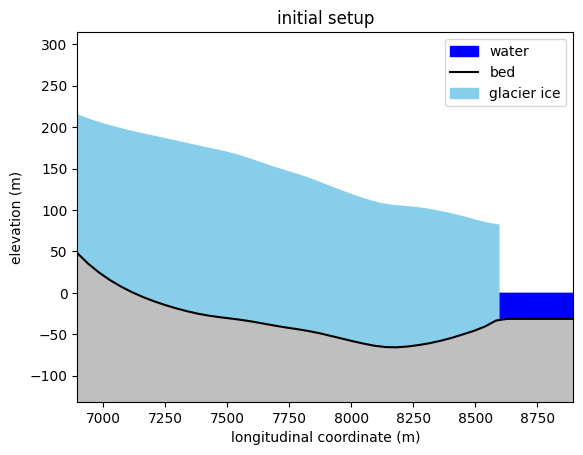

In [11]:
s_array = np.array(icepack.depth_average(s).at(mesh_1.X, tolerance = 1e-10))
base_array = np.array(icepack.depth_average(base).at(mesh_1.X, tolerance = 1e-10))

water_mask = (0 > bed0_array) # & (mesh_0.X > x_t)

plt.figure()
plt.fill_between(mesh_0.X, bed0_array, 0, color = 'blue', where = water_mask, label = 'water')
plt.plot(mesh_0.X, bed0_array, color = 'k', label = 'bed')
plt.fill_between(mesh_1.X, base_array, s_array, color = 'skyblue', label = 'glacier ice')
plt.fill_between(mesh_0.X, y_1, bed0_array, color = '0.75')
plt.legend(loc = 'upper right')
plt.xlabel('longitudinal coordinate (m)')
plt.ylabel('elevation (m)')
plt.xlim(x_1, x_2)
plt.ylim(y_1, y_2)
plt.title('initial setup')
# plt.grid()

 99%|█████████████████████████████████████████████████████████████████████████████████▏| 99/100 [04:05<00:02,  2.59s/it]

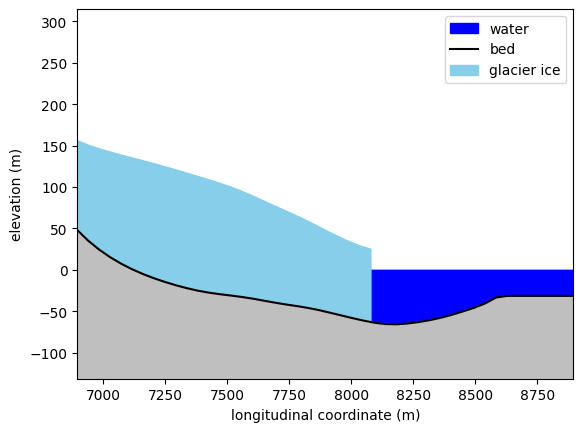

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [04:08<00:00,  2.48s/it]


In [12]:
num_timesteps = int(model_time/Δt)
calving_pressure = 0

for step in trange(num_timesteps):

    flow_model = icepack.models.HybridModel(friction = basal_friction)
    flow_solver = icepack.solvers.FlowSolver(flow_model, **model_opts)

    u = flow_solver.diagnostic_solve(velocity = u, thickness = H, surface = s, fluidity = A, friction = C)
    H = flow_solver.prognostic_solve(Δt, thickness = H, velocity = u, thickness_inflow = H_0, accumulation = a)
    s = icepack.compute_surface(bed = bed, thickness = H)
    base = Function(Q).project(s - H)
    d = Function(Q).project(max_value(-base, 0))

    H_t = H.at(x_t, 0)
    d_t = d.at(x_t, 0)
    u_t = icepack.depth_average(u).at(x_t)
    a_t = a.at(x_t, 0)
    
    f_af = max(ϱ*H_t/d_t - 1, 0.01) #fraction above flotation
    fafs.append(f_af)
    
    calving_pressure += c_1*np.sqrt(H_t*d_t)
    if np.random.random() > 10*Δt*f_af and u_t*Δt + mesh_1.length < mesh_0.length:
        u_c = 0 #no calving
    else:
        u_c = calving_pressure #calve the appropriate length - including any previously suppressed calving
        calving_pressure = 0
    Δx = ((u_c + u_t)*Δt)
    Δxs.append(Δx)
        
    mesh_2 = centerline_mesh(mesh = mesh_1, n_cells = n_cells, extra_length = Δx)
    x_t = mesh_2.length
    
    H = extend_to_mesh(function = H, mesh = mesh_2, ice_free_value = H_t)
    bed = extend_to_mesh(function = bed_0, mesh = mesh_2)
    s = icepack.compute_surface(bed = bed, thickness = H)
    u = extend_to_mesh(function = u, mesh = mesh_2, ice_free_value = u_t)
    a = extend_to_mesh(function = smb_dict[surface_1.year + step*Δt], mesh = mesh_2, ice_free_value = a_t)

    Q = s.function_space()
    base = Function(Q).project(s - H)
    
    mesh_1 = mesh_2

    bed_array = np.array(icepack.depth_average(bed).at(mesh_1.X, tolerance = 1e-10))
    s_array = np.array(icepack.depth_average(s).at(mesh_1.X, tolerance = 1e-10))
    H_array = np.array(icepack.depth_average(H).at(mesh_1.X, tolerance = 1e-10))
    base_array = s_array - H_array
    water_mask = (0 > bed0_array) 
    
    
    plt.figure()
    plt.fill_between(mesh_0.X, bed0_array, 0, color = 'blue', where = water_mask, label = 'water')
    plt.plot(mesh_0.X, bed0_array, color = 'k', label = 'bed')
    plt.fill_between(mesh_1.X, base_array, s_array, color = 'skyblue', label = 'glacier ice')
    plt.fill_between(mesh_0.X, y_1, bed0_array, color = '0.75')
    plt.legend(loc = 'upper right')
    plt.xlabel('longitudinal coordinate (m)')
    plt.ylabel('elevation (m)')
    plt.xlim(x_1, x_2)
    plt.ylim(y_1, y_2)
    # plt.grid()
    plt.savefig(f'{step}') 
    if step < num_timesteps - 1:
        plt.close()
    else:
        plt.show()

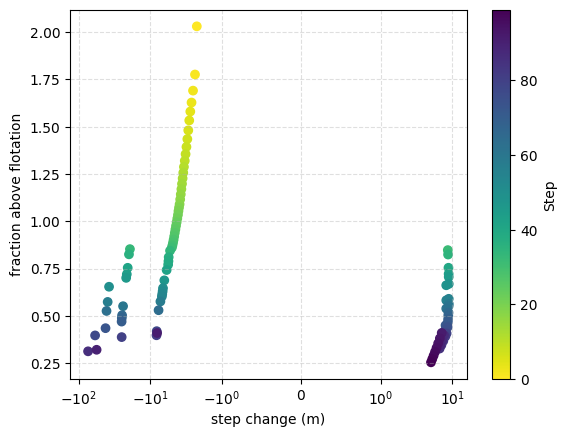

In [13]:
N = len(fafs)
steps = np.arange(N)
cmap = plt.get_cmap('viridis_r')
norm = Normalize(vmin=0, vmax=N-1)

fig, ax = plt.subplots()
sc = ax.scatter(Δxs, fafs, c=steps, cmap=cmap, norm=norm)

# Optional: symlog if you have negatives
ax.set_xscale('symlog', linthresh=1)
# ax.set_yscale('symlog', linthresh=1e-3)

ax.grid(True, which='both', ls='--', alpha=0.4)
ax.set_xlabel('step change (m)')
ax.set_ylabel('fraction above flotation')

fig.colorbar(sc, ax=ax, label='Step')   # <-- use sc, not a bare ScalarMappable
plt.show()